In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "sans-serif",
        "font.sans-serif": "Arial",
        "font.size": "6",
        "legend.loc": "upper left",
    }
)

# Evaluation of false_contacts Simulation Run

## 1. Overview
Comparison of one single REMC with largest cluster against all clustering including all runs. At threshold $3.5 A$ and cluster $1$.

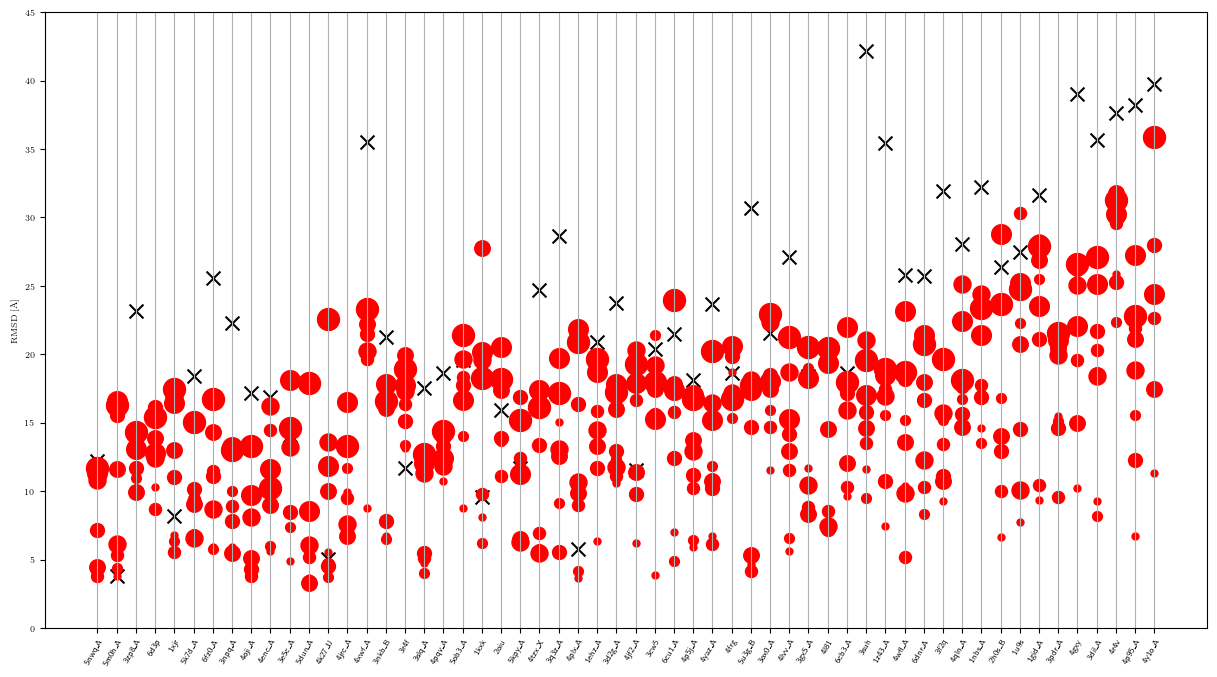

In [2]:
df = pd.read_csv("results.csv", index_col=0)
df_without = pd.read_csv("../FinalConfig/results.csv", index_col=0)
ev1 = df[(df["threshold"] == 3.5) & (df["cluster"] == 1)]
ev2 = df_without[(df_without["threshold"] == 3.5) & (df_without["cluster"] == 1)]
lam = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5]

fig, ax = plt.subplots(figsize=(15, 8))


ax.scatter(
    ev2[ev2["Clustering File"] == "singleA"].sort_values(by="size").RNA,
    ev2[ev2["Clustering File"] == "singleA"].sort_values(by="size").RMSD,
    label=r"$\mathrm{without\ Restraints}$",
    marker="x",
    s=100,
    color="black",
)
for l in lam:
    ax.scatter(
        ev1[ev1["lam"] == l].RNA,
        ev1[ev1["lam"] == l].RMSD,
        label=r"$\mathrm{t}$",
        marker="o",
        s=500 * l,
        color="red",
    )


# ax.legend()
ax.grid(axis="x")
ax.set_ylabel(r"$\mathrm{RMSD\ [\AA]}$")
ax.set_ylim(0, 45)


plt.setp(ax.get_xticklabels(), rotation=60, ha="right", rotation_mode="anchor")

plt.show()
# plt.savefig("fig4.png", transparent=True)

## 2. Beneficial Fraction
The beneficial fraction is the fraction of RNAs for a specific $\lambda$ which has an lower RMSD compared to a run without restraints. 

In [15]:
lam_per = []

for i, l in enumerate(lam):
    lam_per.append([l, 0])
    for index, d in ev1[ev1["lam"] == l].iterrows():
        if (
            d.RMSD
            < ev2[(ev2.RNA == d.RNA) & (ev2["Clustering File"] == "singleA")]
            .iloc[0]
            .RMSD
        ):
            lam_per[i][1] += 1

In [16]:
def get_lam_per(threshold: int) -> tuple[list, list]:
    lam_per_small = []

    for i, l in enumerate(lam):
        lam_per_small.append([l, 0])
        for index, d in ev1[(ev1["lam"] == l) & (ev1["size"] <= threshold)].iterrows():
            if (
                d.RMSD
                < ev2[(ev2.RNA == d.RNA) & (ev2["Clustering File"] == "singleA")]
                .iloc[0]
                .RMSD
            ):
                lam_per_small[i][1] += 1

    lam_per_big = []

    for i, l in enumerate(lam):
        lam_per_big.append([l, 0])
        for index, d in ev1[(ev1["lam"] == l) & (ev1["size"] > threshold)].iterrows():
            if (
                d.RMSD
                < ev2[(ev2.RNA == d.RNA) & (ev2["Clustering File"] == "singleA")]
                .iloc[0]
                .RMSD
            ):
                lam_per_big[i][1] += 1

    return lam_per_small, lam_per_big


def get_size(threshold: int) -> tuple[int, int]:
    return sum((ev1["size"] <= threshold) & (ev1["lam"] == 0.05)), sum(
        (ev1["size"] > threshold) & (ev1["lam"] == 0.05)
    )

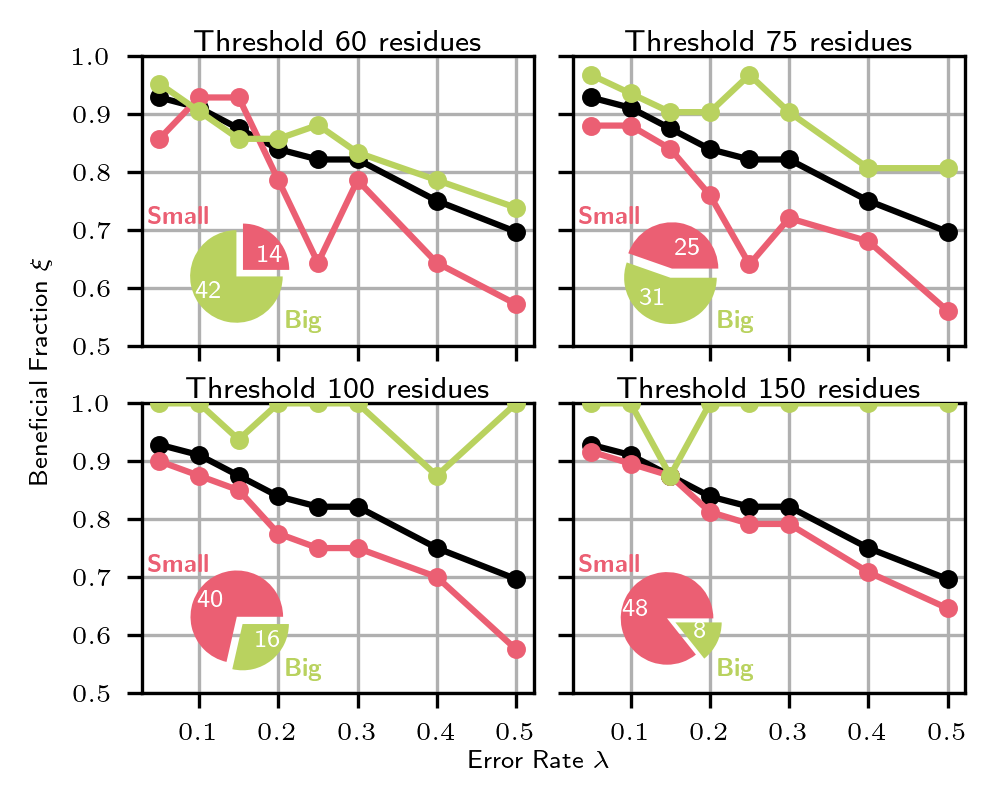

In [17]:
import matplotlib


cm = 1 / 2.54
color_green = (185 / 255, 210 / 255, 95 / 255)
color_red = (235 / 255, 95 / 255, 115 / 255)
fig, ax = plt.subplots(
    2, 2, figsize=(9 * cm, 7 * cm), sharex=True, sharey=True, dpi=300
)


figure_map = {0: (0, 0), 1: (0, 1), 2: (1, 0), 3: (1, 1)}

total = sum(ev1["lam"] == 0.05)
threshold_list = [60, 75, 100, 150]
size = 50

for i, threshold in enumerate(threshold_list):
    lam_per_small, lam_per_big = get_lam_per(threshold)
    total_small, total_big = get_size(threshold)

    ins = ax[figure_map[i]].inset_axes([0.05, 0.05, 0.4, 0.4])
    ins.pie(
        [total_small, total_big],
        colors=[color_red, color_green],
        explode=(0.1, 0.1),
        labels=[total_small, total_big],
        labeldistance=0.45,
        textprops={"color": "w"},
    )

    ax[figure_map[i]].scatter(
        [e[0] for e in lam_per],
        [e[1] / total for e in lam_per],
        marker=".",
        s=size,
        color="black",
        zorder=3,
        label="All",
    )
    ax[figure_map[i]].plot(
        [e[0] for e in lam_per],
        [e[1] / total for e in lam_per],
        color="black",
        zorder=3,
    )

    ax[figure_map[i]].scatter(
        [e[0] for e in lam_per_small],
        [e[1] / total_small for e in lam_per_small],
        marker=".",
        s=size,
        color=color_red,
        zorder=3,
        label=r"$\leq$" + f" {threshold} residues",
    )
    ax[figure_map[i]].plot(
        [e[0] for e in lam_per_small],
        [e[1] / total_small for e in lam_per_small],
        color=color_red,
        zorder=3,
    )

    ax[figure_map[i]].scatter(
        [e[0] for e in lam_per_big],
        [e[1] / total_big for e in lam_per_big],
        marker=".",
        s=size,
        color=color_green,
        zorder=3,
        label=r"$>$" + f" {threshold} residues",
    )
    ax[figure_map[i]].plot(
        [e[0] for e in lam_per_big],
        [e[1] / total_big for e in lam_per_big],
        color=color_green,
        zorder=3,
    )

    ax[figure_map[i]].set_ylim([0.5, 1.0])

    ax[figure_map[i]].xaxis.grid(zorder=0)
    ax[figure_map[i]].yaxis.grid(zorder=1)

    # ax[figure_map[i]].text(
    #     0.3, 0.55, r"$\tau=\ $" + str(threshold), backgroundcolor="white"
    # )
    ax[figure_map[i]].text(0.035, 0.71, r"\textbf{Small}", color=color_red)
    ax[figure_map[i]].text(0.21, 0.53, r"\textbf{Big}", color=color_green)
    ax[figure_map[i]].set_title(f"Threshold {threshold} residues", pad=0)

fig.text(0.5, 0.02, r"Error Rate $\lambda$", ha="center")
fig.text(0.02, 0.5, r"Beneficial Fraction $\xi$", va="center", rotation="vertical")
fig.subplots_adjust(wspace=0.1, hspace=0.2)

plt.show()

#plt.savefig("../Plots/false-con.png", transparent=True, dpi=300)

In [61]:
lam_per

37

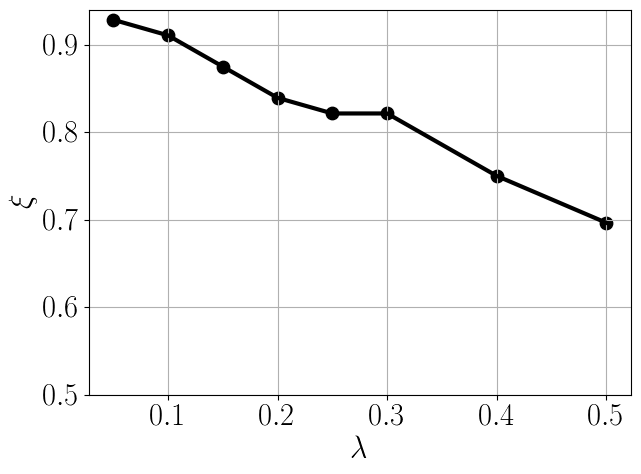

In [21]:
fig, ax = plt.subplots(figsize=(7, 5))

ax.scatter([e[0] for e in lam_per], [e[1]/56 for e in lam_per], color="black", marker="o", s=80)
ax.plot([e[0] for e in lam_per], [e[1]/56 for e in lam_per], color="black", linewidth=3)

ax.set_xlabel(r'$\lambda$')
ax.set_ylabel(r'$\xi$')
ax.set_ylim(bottom=0.5)

ax.grid()

plt.savefig("bene.png", transparent=True)
plt.show()